# Gaussian Mixture Model (GMM) and Expectation Maximization Algorithm (EM)

In this excercise we want to implement the EM algorithm for a GMM distribution.
The GMM distribution is defined as:
\begin{align}
    p(\mathbf{x}) &= \sum_{k=1}^{K} Pr(\omega_k) p(\mathbf{x} | \omega_k) \\
    &= \sum_{k=1}^{K} \pi_k \mathcal{N}(\mathbf{x}; \mu_k, \Sigma_k)
\end{align}
where $\mathbf{x}$ is a vector with $D$ entries.

Your task is to implement the E-Step and M-Step for the GMM Model.

A skeleton for the code is already prepared.

Questions:
 - The GMM is a sum of densities and not of the random variables (RV).
   What is the density of $\mathbf{x}_3 = \mathbf{x}_1 + \mathbf{x}_2$ called,
   when $\mathbf{x}_1$ and $\mathbf{x}_2$ are independent and sampled from a multivariate normal distributions?


In [1]:
%matplotlib inline

from dataclasses import dataclass

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import numpy as np

import pandas as pd
import seaborn as sns

import sklearn.datasets
import sklearn.model_selection
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

# Change the representer for large numpy arrays
def string_function(a):
    if a.size < 50:
        return str(a)
    else:
        return f'array(shape={a.shape}, dtype={a.dtype})'
np.set_string_function(string_function)

In [2]:
CMAP = 'Set1'
N_CMAP = 8

# Helpers
Briefly have a look at these helper functions and try to understand what they are doing

In [3]:
def generate_data(classes, samples_per_class, class_sep=1.0):
    np.random.seed(0)
    d, labels = sklearn.datasets.make_classification(
        n_samples=samples_per_class, n_features=2, n_informative=2, n_redundant=0,
        n_repeated=0, n_classes=classes, n_clusters_per_class=1, weights=None, flip_y=0.01,
        class_sep=class_sep, hypercube=True, shift=0.0, scale=1.0, shuffle=True)
    data = dict()
    tr_x, test_x, tr_label, test_label = \
        sklearn.model_selection.train_test_split(d, labels)
    return {'train': {'x': tr_x, 'label': tr_label}, 'test': {'x': test_x, 'label': test_label}}

In [4]:
def scatterplot(x, y, hue, data, ax=None):
    # Calculate hue_order to prevent random legend order.
    # Insert the colormap
    hue_order = list(sorted(set(data[hue])))
    return sns.scatterplot(data=data, x=x, y=y, hue=hue, palette=CMAP, ax=ax, hue_order=hue_order)

In [5]:
def _set_alpha(rgba, alpha):
    rgba_ = list(rgba)
    if len(rgba_) == 3:
        rgba_.append(alpha)
    elif len(rgba_) == 4:
        rgba_[-1] = alpha
    else:
        raise ValueError(rgba_)
    return tuple(rgba_)

def get_component_cmap(c, N, alpha=1.):
    cmap = plt.get_cmap(CMAP)
    # c *= int(N_CMAP / (N-1))  # for numeric data
    return LinearSegmentedColormap.from_list('test', [_set_alpha(cmap(c), 0), _set_alpha(cmap(c), alpha)])

def plot_prediction(estimator, density='pi * p(x|omega)'):
    n_classes = estimator.n_components
    pred_labels = estimator.predict(data['test']['x'])  
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 7))
    df = pd.DataFrame({
        '$x_1$': data['test']['x'][:, 0],
        '$x_2$': data['test']['x'][:, 1],
        'pred_label': [f'k={l}' for l in pred_labels],
        'true_label': [f'k={l}' for l in data['test']['label']],
        'classified': [
            'correct' if true_label == pred_label else 'wrong'
            for true_label, pred_label in zip(data['test']['label'], pred_labels)
        ]
    })
    scatterplot(data=df, x='$x_1$', y='$x_2$', hue='true_label', ax=ax1)
    scatterplot(data=df, x='$x_1$', y='$x_2$', hue='pred_label', ax=ax2)
    
    x_min, x_max = np.min(data['test']['x'][:, 0]), np.max(data['test']['x'][:, 0])
    y_min, y_max = np.min(data['test']['x'][:, 1]), np.max(data['test']['x'][:, 1])
    X, Y = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

    if density == 'pi * p(x|omega)':
        Z = np.exp(estimator._estimate_log_prob(np.vstack((X.flatten(), Y.flatten())).T))
    elif density == 'p(omega|x)':
        Z = estimator.predict_proba(np.vstack((X.flatten(), Y.flatten())).T)
    else:
        raise ValueError(density)

    for c in range(n_classes):
        alpha = estimator.weights_[c]
        if density == 'p(omega|x)':
            alpha = 1 / n_classes
        ax2.contourf(X, Y, Z[:, c].reshape(X.shape), cmap=get_component_cmap(c, n_classes, alpha))

In [6]:
def plot_data(data):
    _, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 7))
    
    df = pd.DataFrame({
        '$x_1$': data['train']['x'][:, 0],
        '$x_2$': data['train']['x'][:, 1],
        'true_label': [f'k={l}' for l in data['train']['label']],
    })
    scatterplot(data=df, x='$x_1$', y='$x_2$', hue='true_label', ax=ax1)
    ax1.set_title('train data')
    ax1.grid()
    df = pd.DataFrame({
        '$x_1$': data['test']['x'][:, 0],
        '$x_2$': data['test']['x'][:, 1],
        'true_label': [f'k={l}' for l in data['test']['label']],
    })
    scatterplot(data=df, x='$x_1$', y='$x_2$', hue='true_label', ax=ax2)
    ax2.set_title('test data')
    ax2.grid()

# Gaussian data

In [7]:
data = generate_data(3, 1000)

In [8]:
data

{'train': {'x': array(shape=(750, 2), dtype=float64),
  'label': array(shape=(750,), dtype=int64)},
 'test': {'x': array(shape=(250, 2), dtype=float64),
  'label': array(shape=(250,), dtype=int64)}}

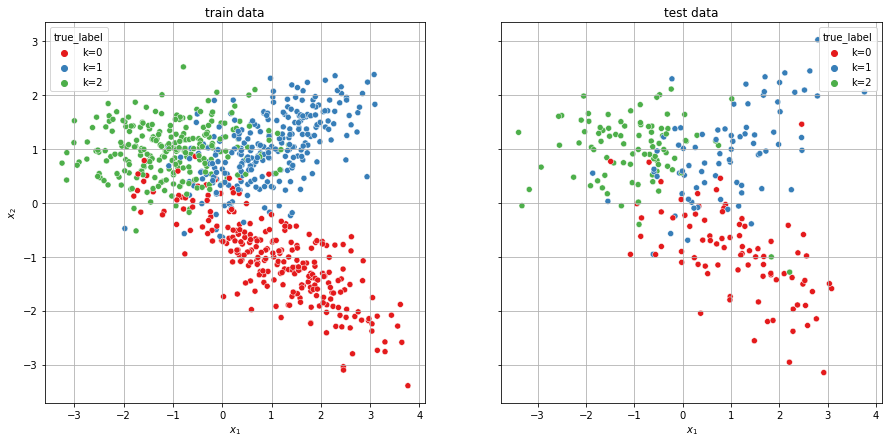

In [9]:
plot_data(data)

# Calculate the mean for each class to use it as an oracle initialization later

In [0]:
means_init = ???
means_init

# Write your own GMM class

Use the skeleton below to write your own GMM which can be fitted to the data with the EM-Algorithm

In [0]:
class GMM:
    def __init__(self, n_components=3, tol=0.001, max_iter=100,
                 means_init=None):
        self.n_components = n_components  # number of clusters
        self.tol = tol  # threshold to stop
        self.max_iter = max_iter  # maximum number of iterations
        self.means_init = means_init
        self.means = None
        self.covariances = None
        self.weights = None
        self.log_likelihoods = None

    @staticmethod
    def _calculate_probabilities_for_gaussian(X, mu, sigma):
        """
        Calculate the probabilities N(x; mu, sigma)
        for each datapoint in X given the parameters mu and sigma

        Args:
            X: datapoints of shape [n_datapoints, n_dims]
            mu_k: mean vector of shape [n_dims]
            sigma_k: covariance matrix of shape [n_dims, n_dims]
            
        Return:
            probabilities for each datapoint [n_datapoints]
        """
        x_centered = X - mu
        exponent = ???  # x_n.T @ sigma @ x_n
        return ??? # ... gaussian probability
    
    def _estimate_log_prob(self, X):
        """
        Calculate the log-probabilities log(p(x|omega)) for each component.

        Args:
            X: datapoints of shape [n_datapoints, n_dims]

        Return:
            log_probabilities: probabilities for each datapoint [n_datapoints, n_components]
        """
        return ???
    
    def _estimate_weighted_log_prob(self, X):
        """
        Calculate the weighted log-probabilities, log(p(x|omega)) + log(pi).

        Args:
            X: datapoints of shape [n_datapoints, n_dims]

        Return:
            weighted_log_probabilities: probabilities for each datapoint [n_datapoints, n_components]
        """
        return ???

    def fit(self, X):

        n_datapoints, n_dims = X.shape

        if self.means_init is None:
            # randomly choose the starting centroids/means
            # as `self.n_components` of the points from datasets
            mu = ???
        else:
            mu = self.means_init

        # initialize the covariance matrices for each Gaussians as
        # an identity matrix. I.e. sigma should be a list with
        # identity matrices of appropriate dimension
        sigma = ???

        # initialize the probabilities/weights for each gaussians
        # with uniform probability
        weights = ???

        # log_likelihoods
        log_likelihoods = []

        # Iterate till max_iters iterations
        for _ in range(self.max_iter):

            # E - Step

            # Create a [n_datapoints, n_components] matrix with the probability
            # for each observation for each component: pi_k * N(x_n; mu_k, sigma_k)
            responsibility_matrix = list()
            for k in range(self.n_components):
                ???
            responsibility_matrix = ???

            # Likelihood computation
            log_likelihood = np.sum(
                np.log(np.sum(responsibility_matrix, axis=1)))
            log_likelihoods.append(log_likelihood)

            # Normalize so that the responsibility matrix is row stochastic
            responsibility_matrix /= ???
            
            # The effective number of datapoints belonging to each gaussian.
            # Calculated by summing over the posterior.
            N_ks = ???

            # M - Step for each component
            for k in range(self.n_components):
                # mean vector
                mu[k] = ???
                x_mu = ???

                # covariance matrix
                sigma[k] = ???

                # weight vector
                weights[k] = ???
            # check for convergence
            if len(log_likelihoods) >= 2:
                if np.abs(log_likelihood - log_likelihoods[-2]) < self.tol:
                    break

        # Set the new parameters
        self.means = mu
        self.means_ = mu  # for API compatibility with sklearn
        self.covariances = sigma
        self.covariances_ = sigma  # for API compatibility with sklearn
        self.weights = weights
        self.weights_ = weights  # for API compatibility with sklearn
        self.log_likelihoods = log_likelihoods

    def predict(self, X):
        """
        Predicts the class affinities for each datapoint.

        Args:
            X: datapoints of size [n_datapoints, n_dims]
        Returns:
            A vector of size [n_datapoints] with the index of the most
            likely component associated with each datapoint
        """
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)

    def predict_proba(self, X):
        """
        Predicts the posterior probabilities for each datapoint for each component.

        Args:
            X: datapoints of size [n_datapoints, n_dims]
        Returns:
            A [n_datapoints, n_components] matrix with the probabilities
            for each datapoint for each component
        """
        return ???

In [0]:
def get_fitted_estimator(n_classes, means_init=None):
    estimator = GMM(means_init=means_init)
    estimator.fit(data['train']['x'])
    return estimator

## Fit a GMM estimator
 - Why are the predicted label sometimes swapped?
 - What is the difference between the two density option for the plot function?
   - Can you explain what they show?

In [0]:

estimator = get_fitted_estimator(3, None)
plot_prediction(estimator, density='pi * p(x|omega)')
plot_prediction(estimator, density='p(omega|x)')

In [0]:
plot_prediction(get_fitted_estimator(3, means_init))

## Score the estimation

One way to score the estimation is to calculate the accuracy.
To calculate the accuracy we need to know if each datapoint is classified correct or wrong.

The function `plot_prediction` defines `classified` for the `pd.DataFrame`.
This can be used as alternative visualisation of the `pred_label` or `true_label`.

 - Change the souce code of `plot_prediction` to show 3 plots.
 - The third plot should show if a point is `correct` or `wrong` `classified`.
 - Try to observe the following when you execute `plot_prediction(get_fitted_estimator(3))`:
    - Most samples are `correct` classified
    - Most samples are `wrong` classified
 - Do you have an idea, what is wrong in the calculation of `classified`?
 - Can you fix it?

# SKlearn

Instead of writing our own code , we can also use an available package, in this case `sklearn`.
Take a look at the `sklearn.mixture` module and especially the class `GaussianMixture`.
Complete the function below and explore the parameter options.

In [0]:
def get_fitted_estimator_sklearn(
        data,
        n_classes,
        covariance_type,
        means_init=None,
        init_params='kmeans',
        max_iter=100,
):
    estimator = ???
    estimator.fit(data['train']['x'])
    return estimator

### Predictions with same number of classes

### Random initialization

In [0]:
estimator = get_fitted_estimator_sklearn(data, 3, 'diag', means_init=None, init_params='random', max_iter=100)
estimator

In [0]:
plot_prediction(get_fitted_estimator_sklearn(data, 3, 'diag', means_init=None, init_params='random', max_iter=100))

### Initialize mean with training data

In [0]:
plot_prediction(get_fitted_estimator_sklearn(data, 3, 'full', means_init=means_init, init_params='random'))

**Try to adjust the number of iterations. Is it possible to get an equally good result with random initialization? What is the advantage of the random initialization?**

### Now try out `kmeans` initialization

In [0]:
plot_prediction(get_fitted_estimator_sklearn(data, 3, 'diag', means_init=None, init_params='kmeans'))

**How does it work? Explain why the colors do not match. What are the (dis)advantages of the kmeans initialization?**

## Predictions with different number of classes

In [0]:
plot_prediction(get_fitted_estimator_sklearn(data, 3, 'diag', means_init=None, init_params='kmeans'))
plot_prediction(get_fitted_estimator_sklearn(data, 4, 'diag', means_init=None, init_params='kmeans'))
plot_prediction(get_fitted_estimator_sklearn(data, 5, 'diag', means_init=None, init_params='kmeans'))

**What is the best segmentation? How would you choose the number of classes?**

## Bayesian GMM

In [0]:
BayesianGaussianMixture?

In [0]:
def get_fitted_bayesian_estimator(data, n_classes, covariance_type, max_iter, weight_concentration_prior, init_params='kmeans', random_state=0):
    estimator = BayesianGaussianMixture(
        ???
    )
    estimator.fit(data['train']['x'])
    return estimator

In [0]:
data = generate_data(3, 1000)

#### Different number of EM iterations

In [0]:
for max_steps in range(1, 1000, 100):
    plot_prediction(get_fitted_bayesian_estimator(data, 6, 'diag', max_steps, None, 'kmeans'))

#### Play around with the parameters. How does the prior influence the result? What happens for random initializations?

In [0]:
# ...